In [1]:
# load packages
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim

/cloud/myenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

In [4]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization""" 
        self.k = k
        self.num_classes = num_classes
        self.T = T
            
        x = prepare_x(data)
        y = get_label(data)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

# Data preparation

In [5]:
# please change the data_path to your local path
# data_path = '/nfs/home/zihaoz/limit_order_book/data'

dec_data = np.loadtxt('../../data/data/Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('../../data/data/Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('../../data/data/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('../../data/data/Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_train.shape, dec_val.shape, dec_test.shape)

(149, 203800) (149, 50950) (149, 139587)


In [6]:
batch_size = 64

dataset_train = Dataset(data=dec_train, k=0, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=0, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=0, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

torch.Size([203701, 1, 100, 40]) torch.Size([203701])


In [8]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

tensor([[[[0.1226, 0.0560, 0.1224,  ..., 0.1724, 0.1215, 0.0277],
          [0.1226, 0.0560, 0.1224,  ..., 0.1724, 0.1215, 0.0277],
          [0.1226, 0.0560, 0.1224,  ..., 0.1724, 0.1215, 0.0277],
          ...,
          [0.1228, 0.0451, 0.1225,  ..., 0.0300, 0.1216, 0.0722],
          [0.1228, 0.0451, 0.1225,  ..., 0.0300, 0.1216, 0.0722],
          [0.1228, 0.0441, 0.1225,  ..., 0.0300, 0.1216, 0.0722]]]],
       dtype=torch.float64)
tensor([2.], dtype=torch.float64)
torch.Size([1, 1, 100, 40]) torch.Size([1])


In [7]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

In [8]:
model = deeplob(y_len = dataset_train.num_classes)
model.to(device)

deeplob(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride

In [11]:
summary(model, (1, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
deeplob                                  --                        --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Model Training


In [11]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            torch.save(model, './savedModels_rightOrder/allstock_C3L_40_1')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses

In [12]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=50)

  2%|▏         | 1/50 [01:01<50:05, 61.34s/it]

model saved
Epoch 1/50, Train Loss: 0.9486,           Validation Loss: 0.9181, Duration: 0:01:01.335766, Best Val Epoch: 0


  4%|▍         | 2/50 [02:01<48:39, 60.81s/it]

model saved
Epoch 2/50, Train Loss: 0.9434,           Validation Loss: 0.9179, Duration: 0:01:00.446601, Best Val Epoch: 1


  6%|▌         | 3/50 [03:00<46:53, 59.85s/it]

model saved
Epoch 3/50, Train Loss: 0.9421,           Validation Loss: 0.9179, Duration: 0:00:58.708078, Best Val Epoch: 2


  8%|▊         | 4/50 [03:59<45:40, 59.57s/it]

model saved
Epoch 4/50, Train Loss: 0.9408,           Validation Loss: 0.9179, Duration: 0:00:59.136094, Best Val Epoch: 3


 10%|█         | 5/50 [04:58<44:27, 59.28s/it]

model saved
Epoch 5/50, Train Loss: 0.9397,           Validation Loss: 0.9179, Duration: 0:00:58.773963, Best Val Epoch: 4


 12%|█▏        | 6/50 [05:59<43:54, 59.87s/it]

model saved
Epoch 6/50, Train Loss: 0.8941,           Validation Loss: 0.9178, Duration: 0:01:01.008785, Best Val Epoch: 5


 14%|█▍        | 7/50 [06:59<43:02, 60.05s/it]

model saved
Epoch 7/50, Train Loss: 0.8599,           Validation Loss: 0.9178, Duration: 0:01:00.412171, Best Val Epoch: 6


 16%|█▌        | 8/50 [08:00<42:15, 60.36s/it]

model saved
Epoch 8/50, Train Loss: 0.8564,           Validation Loss: 0.9178, Duration: 0:01:01.028809, Best Val Epoch: 7


 18%|█▊        | 9/50 [09:01<41:16, 60.41s/it]

model saved
Epoch 9/50, Train Loss: 0.8200,           Validation Loss: 0.8596, Duration: 0:01:00.520690, Best Val Epoch: 8


 20%|██        | 10/50 [10:00<40:06, 60.16s/it]

Epoch 10/50, Train Loss: 0.7976,           Validation Loss: 0.8965, Duration: 0:00:59.605445, Best Val Epoch: 8


 22%|██▏       | 11/50 [10:58<38:37, 59.43s/it]

model saved
Epoch 11/50, Train Loss: 0.7920,           Validation Loss: 0.8588, Duration: 0:00:57.770450, Best Val Epoch: 10


 24%|██▍       | 12/50 [11:57<37:32, 59.26s/it]

model saved
Epoch 12/50, Train Loss: 0.7877,           Validation Loss: 0.8383, Duration: 0:00:58.881909, Best Val Epoch: 11


 26%|██▌       | 13/50 [12:55<36:15, 58.78s/it]

Epoch 13/50, Train Loss: 0.7847,           Validation Loss: 0.8387, Duration: 0:00:57.678695, Best Val Epoch: 11


 28%|██▊       | 14/50 [13:55<35:28, 59.13s/it]

model saved
Epoch 14/50, Train Loss: 0.7817,           Validation Loss: 0.8293, Duration: 0:00:59.923247, Best Val Epoch: 13


 30%|███       | 15/50 [14:54<34:32, 59.21s/it]

model saved
Epoch 15/50, Train Loss: 0.7798,           Validation Loss: 0.8289, Duration: 0:00:59.407165, Best Val Epoch: 14


 32%|███▏      | 16/50 [15:52<33:17, 58.76s/it]

Epoch 16/50, Train Loss: 0.7784,           Validation Loss: 0.8292, Duration: 0:00:57.700096, Best Val Epoch: 14


 34%|███▍      | 17/50 [16:50<32:12, 58.55s/it]

model saved
Epoch 17/50, Train Loss: 0.7765,           Validation Loss: 0.8188, Duration: 0:00:58.079525, Best Val Epoch: 16


 36%|███▌      | 18/50 [17:48<31:12, 58.51s/it]

Epoch 18/50, Train Loss: 0.7745,           Validation Loss: 0.8248, Duration: 0:00:58.418837, Best Val Epoch: 16


 38%|███▊      | 19/50 [18:49<30:34, 59.18s/it]

Epoch 19/50, Train Loss: 0.7727,           Validation Loss: 0.8319, Duration: 0:01:00.719416, Best Val Epoch: 16


 40%|████      | 20/50 [19:46<29:18, 58.62s/it]

Epoch 20/50, Train Loss: 0.7732,           Validation Loss: 0.8270, Duration: 0:00:57.314861, Best Val Epoch: 16


 42%|████▏     | 21/50 [20:43<27:58, 57.87s/it]

Epoch 21/50, Train Loss: 0.7725,           Validation Loss: 0.8199, Duration: 0:00:56.110825, Best Val Epoch: 16


 44%|████▍     | 22/50 [21:39<26:51, 57.54s/it]

Epoch 22/50, Train Loss: 0.7705,           Validation Loss: 0.8215, Duration: 0:00:56.767129, Best Val Epoch: 16


 46%|████▌     | 23/50 [22:37<25:58, 57.71s/it]

Epoch 23/50, Train Loss: 0.7687,           Validation Loss: 0.8644, Duration: 0:00:58.113985, Best Val Epoch: 16


 48%|████▊     | 24/50 [23:36<25:05, 57.92s/it]

Epoch 24/50, Train Loss: 0.7670,           Validation Loss: 0.8190, Duration: 0:00:58.411935, Best Val Epoch: 16


 50%|█████     | 25/50 [24:34<24:11, 58.08s/it]

model saved
Epoch 25/50, Train Loss: 0.7654,           Validation Loss: 0.8186, Duration: 0:00:58.444642, Best Val Epoch: 24


 52%|█████▏    | 26/50 [25:33<23:16, 58.20s/it]

model saved
Epoch 26/50, Train Loss: 0.7637,           Validation Loss: 0.8171, Duration: 0:00:58.481521, Best Val Epoch: 25


 54%|█████▍    | 27/50 [26:31<22:17, 58.14s/it]

Epoch 27/50, Train Loss: 0.7622,           Validation Loss: 0.8258, Duration: 0:00:58.015083, Best Val Epoch: 25


 56%|█████▌    | 28/50 [27:30<21:27, 58.51s/it]

model saved
Epoch 28/50, Train Loss: 0.7605,           Validation Loss: 0.8159, Duration: 0:00:59.347193, Best Val Epoch: 27


 58%|█████▊    | 29/50 [28:28<20:26, 58.40s/it]

Epoch 29/50, Train Loss: 0.7588,           Validation Loss: 0.8165, Duration: 0:00:58.156267, Best Val Epoch: 27


 60%|██████    | 30/50 [29:26<19:22, 58.13s/it]

Epoch 30/50, Train Loss: 0.7569,           Validation Loss: 0.8209, Duration: 0:00:57.508645, Best Val Epoch: 27


 62%|██████▏   | 31/50 [30:25<18:31, 58.50s/it]

Epoch 31/50, Train Loss: 0.7560,           Validation Loss: 0.8186, Duration: 0:00:59.357390, Best Val Epoch: 27


 64%|██████▍   | 32/50 [31:21<17:21, 57.84s/it]

Epoch 32/50, Train Loss: 0.7543,           Validation Loss: 0.8240, Duration: 0:00:56.311329, Best Val Epoch: 27


 66%|██████▌   | 33/50 [32:21<16:30, 58.24s/it]

Epoch 33/50, Train Loss: 0.7524,           Validation Loss: 0.8250, Duration: 0:00:59.165621, Best Val Epoch: 27


 68%|██████▊   | 34/50 [33:19<15:30, 58.16s/it]

Epoch 34/50, Train Loss: 0.7503,           Validation Loss: 0.8310, Duration: 0:00:57.955843, Best Val Epoch: 27


 70%|███████   | 35/50 [34:15<14:26, 57.75s/it]

model saved
Epoch 35/50, Train Loss: 0.7490,           Validation Loss: 0.8132, Duration: 0:00:56.808512, Best Val Epoch: 34


 72%|███████▏  | 36/50 [35:12<13:24, 57.44s/it]

Epoch 36/50, Train Loss: 0.7471,           Validation Loss: 0.8222, Duration: 0:00:56.694932, Best Val Epoch: 34


 74%|███████▍  | 37/50 [36:09<12:26, 57.41s/it]

Epoch 37/50, Train Loss: 0.7457,           Validation Loss: 0.8403, Duration: 0:00:57.336872, Best Val Epoch: 34


 76%|███████▌  | 38/50 [37:07<11:28, 57.39s/it]

Epoch 38/50, Train Loss: 0.7442,           Validation Loss: 0.8159, Duration: 0:00:57.339114, Best Val Epoch: 34


 78%|███████▊  | 39/50 [38:03<10:27, 57.06s/it]

Epoch 39/50, Train Loss: 0.7423,           Validation Loss: 0.8140, Duration: 0:00:56.283610, Best Val Epoch: 34


 80%|████████  | 40/50 [38:58<09:25, 56.50s/it]

Epoch 40/50, Train Loss: 0.7406,           Validation Loss: 0.8154, Duration: 0:00:55.208773, Best Val Epoch: 34


 82%|████████▏ | 41/50 [39:55<08:28, 56.46s/it]

Epoch 41/50, Train Loss: 0.7393,           Validation Loss: 0.8206, Duration: 0:00:56.364541, Best Val Epoch: 34


 84%|████████▍ | 42/50 [40:51<07:30, 56.34s/it]

Epoch 42/50, Train Loss: 0.7380,           Validation Loss: 0.8232, Duration: 0:00:56.040145, Best Val Epoch: 34


 86%|████████▌ | 43/50 [41:48<06:36, 56.66s/it]

Epoch 43/50, Train Loss: 0.7359,           Validation Loss: 0.8152, Duration: 0:00:57.419567, Best Val Epoch: 34


 88%|████████▊ | 44/50 [42:47<05:44, 57.36s/it]

Epoch 44/50, Train Loss: 0.7345,           Validation Loss: 0.8156, Duration: 0:00:59.002191, Best Val Epoch: 34


 90%|█████████ | 45/50 [43:46<04:49, 57.83s/it]

Epoch 45/50, Train Loss: 0.7331,           Validation Loss: 0.8168, Duration: 0:00:58.915377, Best Val Epoch: 34


 92%|█████████▏| 46/50 [44:44<03:52, 58.02s/it]

Epoch 46/50, Train Loss: 0.7317,           Validation Loss: 0.8159, Duration: 0:00:58.467194, Best Val Epoch: 34


 94%|█████████▍| 47/50 [45:41<02:52, 57.57s/it]

Epoch 47/50, Train Loss: 0.7301,           Validation Loss: 0.8139, Duration: 0:00:56.503618, Best Val Epoch: 34


 96%|█████████▌| 48/50 [46:39<01:55, 57.76s/it]

Epoch 48/50, Train Loss: 0.7289,           Validation Loss: 0.8159, Duration: 0:00:58.194576, Best Val Epoch: 34


 98%|█████████▊| 49/50 [47:39<00:58, 58.25s/it]

Epoch 49/50, Train Loss: 0.7269,           Validation Loss: 0.8153, Duration: 0:00:59.408113, Best Val Epoch: 34


100%|██████████| 50/50 [48:37<00:00, 58.34s/it]

Epoch 50/50, Train Loss: 0.7264,           Validation Loss: 0.8170, Duration: 0:00:57.947700, Best Val Epoch: 34


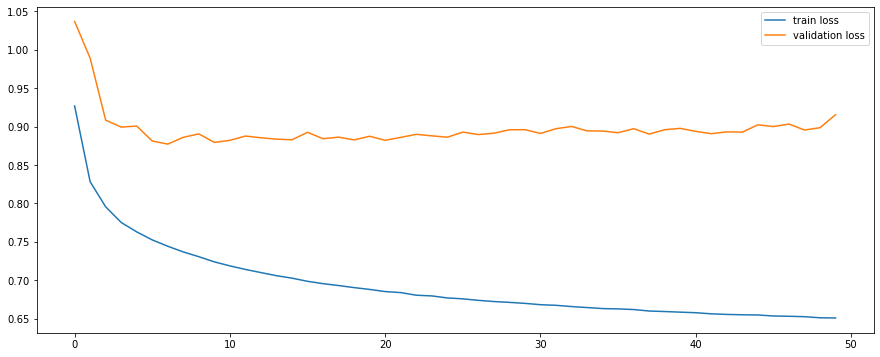

In [15]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

# Model Testing

In [13]:
model = torch.load('./savedModels_rightOrder/allstock_C3L_40_1')
# model = torch.load('./savedModels_rightOrder/best_val_model_pytorch')
n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.8182


In [14]:
# model = torch.load('best_val_model_pytorch')
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    

In [15]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.8181635696260611
              precision    recall  f1-score   support

           0     0.6843    0.5149    0.5877     21127
           1     0.8480    0.9509    0.8965     98602
           2     0.7282    0.4801    0.5787     19759

    accuracy                         0.8182    139488
   macro avg     0.7535    0.6486    0.6876    139488
weighted avg     0.8062    0.8182    0.8047    139488

